In [1]:
"""
Created on Saturday Januyaray 04, 2025

@author: AFTAB HASSAN

"""
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.simplefilter('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_absolute_percentage_error


import itertools
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def CalMape(actual_data, fit_data, term):
    #term  = 12
    lastActualData = actual_data[-term:]
    lastFitData    = fit_data[-term:]        
    i = 0
    count = 0
    ape = 0
    for actualVal in lastActualData:
        #print(actualVal,lastFitData[i])
        if(actualVal != 0):
            val = (abs(actualVal - lastFitData[i])/actualVal)*100
            #val=abs(val)
            #print(val)
            if(val <100):
                count = count + 1
                ape  = ape + val       
        i = i+1
        
    if(count!=0):
        mape_cal = (ape/count)
    else:
        mape_cal=99
            
    if(math.isnan(mape_cal)):        
            return 0
    else:      
        return mape_cal

In [3]:
def CalWMape(actual_data, fit_data, term):
    lastActualData = actual_data[-term:]
    lastFitData    = fit_data[-term:]        
    i=0
    count = 0
    sump_actual=0
    sum_actual_fitted=0
    
    for actualVal in lastActualData:
        if(actualVal != 0):
            sum_actual_fitted += abs(actualVal - lastFitData[i])
            sump_actual +=actualVal
            count = count + 1        
        i = i+1     
          
    if(count!=0):
        wmape_cal = (sum_actual_fitted/sump_actual)*100
    else:
        wmape_cal=99        
     
    if(np.isnan(wmape_cal).any()):        
        return 0
    else:      
        return wmape_cal  

In [4]:
output=[]
temp_output=[]
# Load Data 

df = pd.read_csv('sales_data1.csv')
col=['ALL_DATE','Region','SKU','Type','QTY']
df.columns=col
df["ALL_DATE"]=pd.to_datetime(df["ALL_DATE"],format="%d-%m-%Y")

In [5]:
# display head data
df.head()

,ALL_DATE,Region,SKU,Type,QTY
0,2021-01-01,Hyderabad,SKU1,Sales,768.128
1,2021-02-01,Hyderabad,SKU1,Sales,802.638
2,2021-03-01,Hyderabad,SKU1,Sales,879.206
3,2021-04-01,Hyderabad,SKU1,Sales,131.580
4,2021-05-01,Hyderabad,SKU1,Sales,123.080


In [6]:
# display tail data
df.tail()

,ALL_DATE,Region,SKU,Type,QTY
31,2023-08-01,Hyderabad,SKU1,Sales,2717.3794
32,2023-09-01,Hyderabad,SKU1,Sales,2929.4423
33,2023-10-01,Hyderabad,SKU1,Sales,3100.3416
34,2023-11-01,Hyderabad,SKU1,Sales,3339.3794
35,2023-12-01,Hyderabad,SKU1,Sales,3729.4423


In [7]:
df.describe()

,ALL_DATE,QTY
count,36,36.000000
mean,2022-06-16 12:00:00,1266.127908
min,2021-01-01 00:00:00,123.080000
25%,2021-09-23 12:00:00,561.732400
50%,2022-06-16 00:00:00,898.149450
75%,2023-03-08 18:00:00,1821.466575
max,2023-12-01 00:00:00,3729.442300
std,NaN,941.664929


In [8]:
df.shape

(36, 5)

In [9]:
# display column name
print(df.columns)

df.drop(["Type"],axis=1,inplace=True,errors="ignore")

Index(['ALL_DATE', 'Region', 'SKU', 'Type', 'QTY'], dtype='object')


In [10]:
df.shape

(36, 4)

In [11]:
df['QTY'].describe()

count      36.000000
mean     1266.127908
std       941.664929
min       123.080000
25%       561.732400
50%       898.149450
75%      1821.466575
max      3729.442300
Name: QTY, dtype: float64

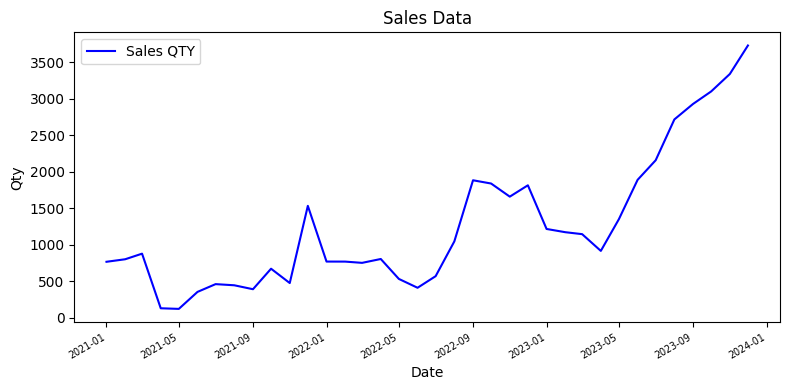

In [12]:
# Plotting the results for train dataset
plt.figure(figsize=(8, 4))
plt.plot( df['ALL_DATE'], df['QTY'], label='Sales QTY', color='blue')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data')
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

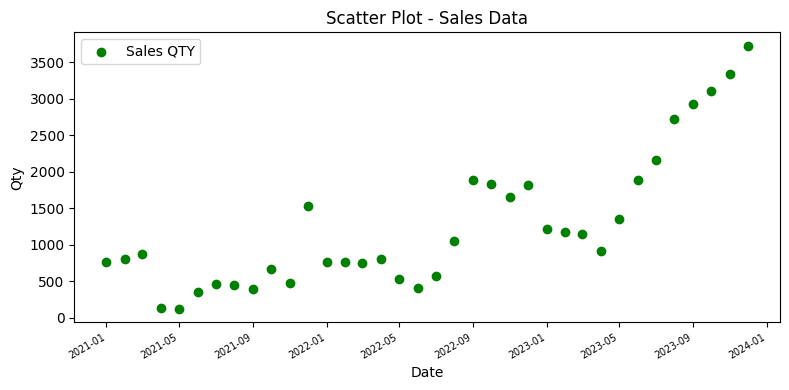

In [13]:
# Plotting the results for train dataset
plt.figure(figsize=(8, 4))
plt.scatter( df['ALL_DATE'], df['QTY'], label='Sales QTY', color='green')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Scatter Plot - Sales Data')
plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
def evaluate_arima_order (data):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(1,4)
    d = range(1,3)
    q = range(1,4)
        
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))
    #print(pdq)
        
    best_aic = np.inf
    best_pdq = None
    temp_model = None
    for param in pdq:   
        temp_model = ARIMA(data,order=param)
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param 
    print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))  
      
    return best_pdq

In [15]:
def ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column):      
        
    mod = ARIMA(orig_data, order=best_pdq)
    res = mod.fit()  
    pred_data = res.predict()  
        
    forecasted_value = res.forecast(steps = step)        
    #print("forecasted Value",forecasted_value)
    
    # plt.plot(train_data["ALL_DATE"],orig_data,label ='Original')
    # plt.plot(train_data["ALL_DATE"],pred_data,label ='ARIMA Fit')
   
    # plt.legend()
    # plt.axis()
    # plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
    # #plt.gcf().autofmt_xdate()
    # plt.tight_layout()
    # plt.show() 
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    print("ARIMA Train MAPE : ",wmape)


    mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    print("ARIMA Test MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data

In [16]:
def evaluate_sarima_order (data):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))        
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
        
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    temp_model = None
    for param in pdq:   
        for param_seasonal in seasonal_pdq: 
            temp_model = SARIMAX(data,order=param,seasonal_order = param_seasonal,enforce_invertibility=True,enforce_stationarity=False)
            results = temp_model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
    print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic)) 
    
    return  best_pdq,best_seasonal_pdq

In [17]:
def SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column):        
        
    mod = SARIMAX(orig_data,order=best_pdq,seasonal_order=best_seasonal_pdq)
    res = mod.fit(disp=False)     
    pred_data = res.predict()    
        
    forecasted_value = res.forecast(steps = step)        
    #print("forecasted Value",forecasted_value)
    
    # plt.plot(train_data["ALL_DATE"],orig_data,label ='Original')
    # plt.plot(train_data["ALL_DATE"],pred_data,label ='SARIMA Fit')
   
    # plt.legend()
    # plt.axis()
    # plt.xticks(rotation=90, fontweight='light',  fontsize='x-small',)
    # #plt.gcf().autofmt_xdate()
    # plt.tight_layout()
    # plt.show() 
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    print("SARIMA Train MAPE : ",wmape)


    mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    print("SARIMA Test MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data


In [18]:
def Holt_Winters_Model(step,orig_data,model_type,train_data,test_data,sales_column):  
    #print("In holtz winter")      
    if(model_type=='add'):
        mod = ExponentialSmoothing(orig_data , initialization_method= 'legacy-heuristic',seasonal_periods=12,trend=None, seasonal='add')
    else:
        mod = ExponentialSmoothing(orig_data ,initialization_method= 'legacy-heuristic',seasonal_periods=12 ,trend='mul',seasonal='mul')
        
    res = mod.fit(optimized=True,use_brute=True)  
    #print(res.summary())
   
    pred_data = res.fittedvalues

    # plt.figure(figsize=(12,8))
    # plt.plot(train_data["ALL_DATE"],orig_data,label ='Original')
    # plt.plot(train_data["ALL_DATE"],pred_data,label ='HW-'+model_type+' Fit')    
    # plt.legend()
    # plt.axis()
    # plt.xticks(rotation=60, fontweight='light',  fontsize='x-small',)
    # #plt.gcf().autofmt_xdate()
    # plt.tight_layout()
    # plt.show()  
    
    forecasted_value = res.forecast(steps = step)
    #print("forecasted Value",forecasted_value)
    
    wmape=round(CalMape(orig_data,pred_data,len(pred_data)),3)
    print("Train Holt_Winters_Model MAPE : ",wmape)
    
    mape=round(CalMape(test_data[sales_column],forecasted_value,len(forecasted_value)),3)
    print("Test Holt_Winters_Model MAPE : ",mape)
    return np.round(forecasted_value,3),mape,wmape,pred_data


In [19]:
def save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,inc_loop,sales_qty):
    i=inc_loop
    negFlag=1
    sales_qty=float(sales_qty)
    #print("Sales QTY = ",sales_qty)
    for fvalue in forecasted_value:                      
        if(fvalue<0):
            negFlag=0
            break            
    
    if(negFlag==1):            
        for fvalue in forecasted_value: 
            fvalue=round(float(fvalue),3)       
            #i+=1
            if(math.isnan(fvalue)==True):  
                #print(np.mean(orig_data))
                MaxFvalue = round(float(np.mean(orig_data)),3)
                temp_output.append([start_year,i,area_code,psku_code,model_name,0,0,MaxFvalue,sales_qty])
            else:
                temp_output.append([start_year,i,area_code,psku_code,model_name,round(float(wmape),3),round(float(mape),3),fvalue,sales_qty])
    else:
        for fvalue in forecasted_value:  
            fvalue=round(float(fvalue),3)              
            #i+=1
            if(math.isnan(fvalue)==True or fvalue<0): 
                #print(">>>>>>>",np.mean(orig_data))
                MaxFvalue = round(float(np.mean(orig_data)),3)                
                temp_output.append([start_year,i,area_code,psku_code,model_name,0,0,MaxFvalue,sales_qty])
            else:
                temp_output.append([start_year,i,area_code,psku_code,model_name,round(float(wmape),3),round(float(mape),3),fvalue,sales_qty])
    


In [20]:
def forcast_output_CSV(output,sales_column):
    #print("Result is writing into csv")
    
    data=[]   

    for x in output:
        #print ('x=',x)   
        start_year=x[0]
        variable='X'+str(x[1])
        region = x[2]
        sku_name=x[3]     
        model_name=x[4] 
        accuracy_wmape=x[5]
        accuracy_mape=x[6]      
        value=x[7]
        sales_qty=x[8]

        #print(fc_model_code,sku_name,model_name,accuracy_me,accuracy_rsme,accuracy_mae,accuracy_mpe,accuracy_mape,accuracy_mase,variable,value)
        data.append([start_year,region,sku_name,model_name,accuracy_wmape,accuracy_mape,variable,value,sales_qty])
        
    fp=open("output/ForecastedResult_"+sales_column+".csv","w")                                        

    header='Star Year'+','+'Region'+','+'SKU'+','+'Model Name'+','+'Overall MAPE'+','+'Test MAPE'+','+'Steps'+','+'Forecast QTY' +','+'Sales QTY'
            
    fp.writelines(header)
    fp.write('\n')
    
    for x in data:
        #print ('x=',x)
        temp=""         
        for i in range(len(x)-1):
            temp=temp+str(x[i])+','
            
        temp=temp+str(x[len(x)-1])
    
        fp.writelines(temp)
        fp.write('\n')
    
    fp.close()


In [21]:
def fitted_output_CSV(temp_output,sales_column):
    print("Result is writing into fitted_output_CSV")
        
    fp=open("output/FittedResult_"+sales_column+".csv","w")                                        

    header='Date'+','+'Region'+','+'SKU'+','+'Model Name'+','+'Sales QTY' +','+'Fitted QTY'
            
    fp.writelines(header)
    fp.write('\n')
    
    for x in temp_output:
        #print ('x=',x)
        temp=""         
        for i in range(len(x)-1):
            temp=temp+str(x[i])+','
            
        temp=temp+str(x[len(x)-1])
    
        fp.writelines(temp)
        fp.write('\n')
    
    fp.close()

In [22]:
def mape_recalculate(temp_result):  
    temp_wmape=[]
    temp=[]
    i = 0
    count = 0
    ape = 0
    for item in temp_result:
        #print(actualVal,lastFitData[i])
        temp_wmape.append(item[5])
        actualVal=item[8]
        forecastVal=item[7]
        if(actualVal != 0):
            val = (abs(actualVal - forecastVal)/actualVal)*100
            if(val <100):
                count = count + 1
                ape  = ape + val       
        i = i+1
        
    if(count!=0):
        mape_cal = (ape/count)
    else:
        mape_cal=99
            
    if(math.isnan(mape_cal)):        
            mape_cal=0

    #print(mape_cal)
    avg_wmape=sum(temp_wmape)/len(temp_wmape)
    for x in temp_result:
        x[5]=round(avg_wmape,3)
        x[6]=round(mape_cal,3)
        temp.append(x)
    return temp

In [23]:
sales_column='QTY'
output=[]
sales_fitted_values=[]
monthstep=3
MultiModelInfo={'ARIMA':3,'SARIMA':3,'HWADD':3,'HWMUL':3}
#MultiModelInfo={'ARIMA':3}
for sel_model_name,month_step in MultiModelInfo.items():
    model_on_off=[0,0,0,0]
    #model_on_off=[1,1,1,1,1,1,1]
    monthstep = month_step        
    if(sel_model_name=="ARIMA"):
        model_on_off[0]=1
    elif(sel_model_name=="SARIMA"):
        model_on_off[1]=1
    elif(sel_model_name=="HWADD"):
        model_on_off[2]=1
    elif(sel_model_name=="HWMUL"):
        model_on_off[3]=1                 
    else:
        model_on_off[0]=1    
     
    print("Selected Model is executing",sel_model_name)
    area= set(list(df["Region"]))
    
    for area_code in area:    
        if(pd.isna(area_code)):
            continue
        df_area_temp=df[df['Region'].isin([area_code])]
        psku = set(list(df_area_temp["SKU"]))     
        for psku_code in psku:
            print(area_code,psku_code)    
            df_temp=df_area_temp[df_area_temp['SKU'].isin([psku_code])] 
            train_length=30
            test_length=len(df_temp)-train_length
            loop_Step=0
            temp_output=[]
            for k in range(0,test_length,1):
                train_data=df_temp.iloc[:train_length+k,]
                test_data=df_temp.iloc[train_length+k:train_length+k+1,]
                #print("k = ",k)
                datapoint=len(train_data)                
                #print("Train Data Points  ",len(train_data))
                #print("Test Data Points  ",len(test_data))
                if(datapoint==0 ):            
                    continue 
                sales_qty=np.asarray(test_data[sales_column])[0]
                #print(sales_qty)
                product=list(train_data['SKU'])[0]
                        
                start_date=list(train_data['ALL_DATE'])[0]
                #print("Start Date ",start_date)
                start_year = start_date.year
                #print("Start Year ",start_year)            
                
                orig_data = np.asarray(train_data[sales_column])  
                date_data = list(train_data["ALL_DATE"])
                zerocount = (train_data[sales_column] <= 0).sum()
                #print(orig_data)  
                #step=len(test_data)       
                step=1
                loop_Step=loop_Step+1
                #print(datapoint,zerocount,zerocount<=int(datapoint*0.80)) 
                
                # result = seasonal_decompose(orig_data, model='additive', period=12)
                # result.plot()
                # plt.show()                
                    
                if(model_on_off[0]==1):
                    model_name="ARIMA" 
                    #print(model_name," Model is executing")
                    best_pdq=evaluate_arima_order(orig_data)
                    best_pdq=(1,2,1)                       
                    forecasted_value,mape,wmape,fittedValue = ARIMA_Model(step,orig_data,best_pdq,train_data,test_data,sales_column)
                    #print("ARIMA Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[1]==1):
                    model_name="SARIMA" 
                    #print(model_name," Model is executing")
                    #best_pdq,best_seasonal_pdq=evaluate_sarima_order(orig_data)
                    best_pdq,best_seasonal_pdq=(1,1,1),(1,1,1,12)                       
                    forecasted_value,mape,wmape,fittedValue = SARIMA_Model(step,orig_data,best_pdq,best_seasonal_pdq,train_data,test_data,sales_column)
                    #print("SARIMA Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[2]==1):
                    model_name="HWADD"    
                    #print(model_name," Model is executing")
                    forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'add',train_data,test_data,sales_column)                
                    #print("HOLT Winters Additive Model QTY data forecasted value : ",forecasted_value,mape,wmape)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                if(model_on_off[3]==1):            
                    model_name="HWMUL"    
                    #print(model_name," Model is executing")
                    forecasted_value,mape,wmape,fittedValue = Holt_Winters_Model(step,orig_data,'mul',train_data,test_data,sales_column)                
                    #print("HOLT Winters Multiplicative Model QTY data forecasted value : ",forecasted_value)
                    save_output(start_year,area_code,psku_code,model_name,mape,wmape,forecasted_value,orig_data,loop_Step,sales_qty)
                
                if(k==0):         
                    for indx in range(len(orig_data)):
                        # try:
                        #     ftValue = fittedValue[indx]
                        # except IndexError:
                        #     ftValue = None                    
                        sales_fitted_values.append([date_data[indx],area_code,psku_code,model_name,orig_data[indx],fittedValue[indx]])
            #print(temp_output)
            temp_output=mape_recalculate(temp_output)
            for item in temp_output:
                output.append(item)
print("Forecast generated successfully!")
forcast_output_CSV(output,sales_column)

Selected Model is executing ARIMA
Hyderabad SKU1
Best ARIMA (1, 2, 1) model - AIC:423.2771570445305
ARIMA Train MAPE :  30.262
ARIMA Test MAPE :  13.373
Best ARIMA (1, 2, 1) model - AIC:437.585196340021
ARIMA Train MAPE :  30.154
ARIMA Test MAPE :  19.503
Best ARIMA (1, 2, 1) model - AIC:453.14273659973935
ARIMA Train MAPE :  27.631
ARIMA Test MAPE :  6.074
Best ARIMA (1, 2, 1) model - AIC:467.1489097282065
ARIMA Train MAPE :  24.378
ARIMA Test MAPE :  3.455
Best ARIMA (1, 2, 1) model - AIC:481.01178110839624
ARIMA Train MAPE :  23.629
ARIMA Test MAPE :  5.084
Best ARIMA (1, 2, 1) model - AIC:494.90206158182565
ARIMA Train MAPE :  23.107
ARIMA Test MAPE :  7.574
Selected Model is executing SARIMA
Hyderabad SKU1
SARIMA Train MAPE :  31.027
SARIMA Test MAPE :  3.212
SARIMA Train MAPE :  28.137
SARIMA Test MAPE :  15.237
SARIMA Train MAPE :  30.465
SARIMA Test MAPE :  2.284
SARIMA Train MAPE :  26.743
SARIMA Test MAPE :  7.502
SARIMA Train MAPE :  26.088
SARIMA Test MAPE :  9.355
SARIMA T

In [24]:
fitted_output_CSV(sales_fitted_values,sales_column)

Result is writing into fitted_output_CSV
